In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/tama/220119_tama.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
# df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-19 13:00:00,#tama954🟢(水曜)
1,2022-01-19 13:00:03,突然小声になるツインタワーの片側の人ｗ #tama954
2,2022-01-19 13:00:28,先週のクロストークで『生活は踊る』から好きな鍋は？ 赤江さん「豆乳鍋」 大吉先生「モツ鍋」 ...
3,2022-01-19 13:00:30,#tama954
4,2022-01-19 13:00:51,愛が一番アイフル～♪からの #博多大吉 先生と赤江工場長による 水曜 #たまむすび 始まった...
...,...,...
1246,2022-01-19 15:31:19,水曜のラストはもやもやする内容のメールが読まれる傾向 こないだのマット？タオル？使わないおじ...
1247,2022-01-19 15:31:20,赤江さん、大吉先生、おつかれさまでしたー #tama954
1248,2022-01-19 15:33:38,メールの記録見たけど ないな 思い違いか #tama954
1249,2022-01-19 15:33:51,昔の思い出はしょうがないでしょ、話しちゃったのはアレだけど。#tama954


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-19 13:00:00,水曜
1,2022-01-19 13:00:03,突然小声になるツインタワーの片側の人w
2,2022-01-19 13:00:28,先週のクロストークで生活は踊るから好きな鍋は赤江さん豆乳鍋大吉先生モツ鍋赤江さんキムチもと答...
3,2022-01-19 13:00:30,
4,2022-01-19 13:00:51,愛が一番アイフル♪からの先生と赤江工場長による水曜始まった
...,...,...
1246,2022-01-19 15:31:19,水曜のラストはもやもやする内容のメールが読まれる傾向こないだのマットタオル使わないおじさんとか
1247,2022-01-19 15:31:20,赤江さん大吉先生おつかれさまでたー
1248,2022-01-19 15:33:38,メールの記録見たけどないな思い違いか
1249,2022-01-19 15:33:51,昔の思い出はょうがないでょ話ちゃったのはアレだけど


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-19 13:00:00,水曜,[水曜]
1,2022-01-19 13:00:03,突然小声になるツインタワーの片側の人w,"[突然, 小声, なる, ツインタワー, 片側, 人, w]"
2,2022-01-19 13:00:28,先週のクロストークで生活は踊るから好きな鍋は赤江さん豆乳鍋大吉先生モツ鍋赤江さんキムチもと答...,"[先週, クロストーク, 生活, 踊る, 好き, 鍋, 赤江, さん, 豆乳鍋, 大吉, 先..."
3,2022-01-19 13:00:30,,0
4,2022-01-19 13:00:51,愛が一番アイフル♪からの先生と赤江工場長による水曜始まった,"[愛, 一番, アイフル, 先生, 赤江, 工場長, 水曜, 始まっ]"
...,...,...,...
1246,2022-01-19 15:31:19,水曜のラストはもやもやする内容のメールが読まれる傾向こないだのマットタオル使わないおじさんとか,"[水曜, ラスト, もやもや, する, 内容, メール, 読ま, れる, 傾向, こないだ,..."
1247,2022-01-19 15:31:20,赤江さん大吉先生おつかれさまでたー,"[赤江, さん, 大吉, 先生, おつかれさま, ー]"
1248,2022-01-19 15:33:38,メールの記録見たけどないな思い違いか,"[メール, 記録, 見, ない, 思い違い]"
1249,2022-01-19 15:33:51,昔の思い出はょうがないでょ話ちゃったのはアレだけど,"[昔, 思い出, ょうがないでょ, 話, ちゃっ, の, アレ]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-19 13:00:00,"[水曜, 突然, 小声, なる, ツインタワー, 片側, 人, w, 先週, クロストーク,..."
1,2022-01-19 13:01:00,"[モノタロウ, モノタロウ, 今日, スタジオ, 大吉, 大黒様, 荷物, あふれる, 日,..."
2,2022-01-19 13:02:00,"[memo, 大吉, 大黒様, 荷物, 届い, 赤江珠緒, さん, oo, タオル, エコ,..."
3,2022-01-19 13:03:00,"[そっか, 今日, 間寛平, 師匠, 出演, ん, 0時, 寛平, 師匠, 刺さ, れる, ..."
4,2022-01-19 13:04:00,"[呼び込み, セブンインスタ, twitter, アップ, 期待, ウルトラ, 呼び込み君,..."
...,...,...
150,2022-01-19 15:30:00,"[赤江, さん, 大吉, 先生, で, タイムカプセル, 校舎, 建て替え, 校内, 配置,..."
151,2022-01-19 15:31:00,"[トニー, さん, 話, 面白かっ, 先, 展覧会, 話, 聞く, 日, 生き, 思える, ..."
152,2022-01-19 15:32:00,[]
153,2022-01-19 15:33:00,"[メール, 記録, 見, ない, 思い違い, 昔, 思い出, ょうがないでょ, 話, ちゃっ..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
150    None
151    None
152    None
153    None
154    None
Length: 155, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-19 13:00:00,"[1.7343487, -0.2963022, -0.46286958, 0.1045091..."
1,2022-01-19 13:00:03,"[-0.8482104, 0.36697552, -0.20989047, -0.92074..."
2,2022-01-19 13:00:28,"[-0.35031316, -0.09149703, 0.16377458, -0.7447..."
3,2022-01-19 13:00:30,0
4,2022-01-19 13:00:51,"[0.18666801, -0.031016514, 0.05330886, 0.28685..."
...,...,...
1246,2022-01-19 15:31:19,"[-0.23594509, 0.35608333, -0.9266233, -0.62438..."
1247,2022-01-19 15:31:20,"[-0.34638742, -0.030590912, 0.6481621, -0.2014..."
1248,2022-01-19 15:33:38,"[-1.0112482, 0.4529037, -1.2219297, -0.2025228..."
1249,2022-01-19 15:33:51,"[-0.078902155, -0.61023736, -1.082698, -0.4475..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-19 13:00:00,"[[1.7343487, -0.2963022, -0.46286958, 0.104509..."
1,2022-01-19 13:01:00,"[[-0.24303137, 0.060681038, -0.6303128, -0.266..."
2,2022-01-19 13:02:00,"[[-0.4305764, -0.17326802, 0.57964474, -0.2911..."
3,2022-01-19 13:03:00,"[[-1.1611313, 0.29489988, -0.6044603, 1.522579..."
4,2022-01-19 13:04:00,"[[-0.057707876, -1.253437, -1.0093622, -0.8242..."
...,...,...
150,2022-01-19 15:30:00,"[[-0.27312183, 0.10658004, 0.42891788, -0.0727..."
151,2022-01-19 15:31:00,"[[0.2602832, -0.026465578, -0.9268798, 0.30614..."
152,2022-01-19 15:32:00,[]
153,2022-01-19 15:33:00,"[[-1.0112482, 0.4529037, -1.2219297, -0.202522..."


In [13]:
df_vectors.to_csv('vectors.csv', index=False)

In [14]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [15]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-19 13:00:00,0.218002,0.284564,0.440106,0.325315,0.177717
1,2022-01-19 13:01:00,0.034992,0.260457,0.350479,0.208262,0.174299
2,2022-01-19 13:02:00,0.107183,0.269416,0.427590,0.291542,0.211196
3,2022-01-19 13:03:00,0.165602,0.263882,0.398246,0.269040,0.155339
4,2022-01-19 13:04:00,0.165765,0.241619,0.324266,0.243911,0.133976
...,...,...,...,...,...,...
150,2022-01-19 15:30:00,0.274786,0.315534,0.476969,0.365331,0.158118
151,2022-01-19 15:31:00,0.381142,0.473323,0.514733,0.439476,0.111671
152,2022-01-19 15:32:00,0.000000,0.000000,0.000000,0.000000,0.000000
153,2022-01-19 15:33:00,0.451492,0.451492,0.451492,0.451492,0.000000


In [16]:
df_vectors.to_csv('similarity.csv', index=False)


In [17]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220119_tama/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.218002,0.284564,0.440106,0.325315,0.177717,5
1,2,0.034992,0.260457,0.350479,0.208262,0.174299,6
2,3,0.107183,0.269416,0.427590,0.291542,0.211196,6
3,4,0.165602,0.263882,0.398246,0.269040,0.155339,10
4,5,0.165765,0.241619,0.324266,0.243911,0.133976,10
...,...,...,...,...,...,...,...
150,151,0.274786,0.315534,0.476969,0.365331,0.158118,4
151,152,0.381142,0.473323,0.514733,0.439476,0.111671,3
152,153,0.000000,0.000000,0.000000,0.000000,0.000000,0
153,154,0.451492,0.451492,0.451492,0.451492,0.000000,2


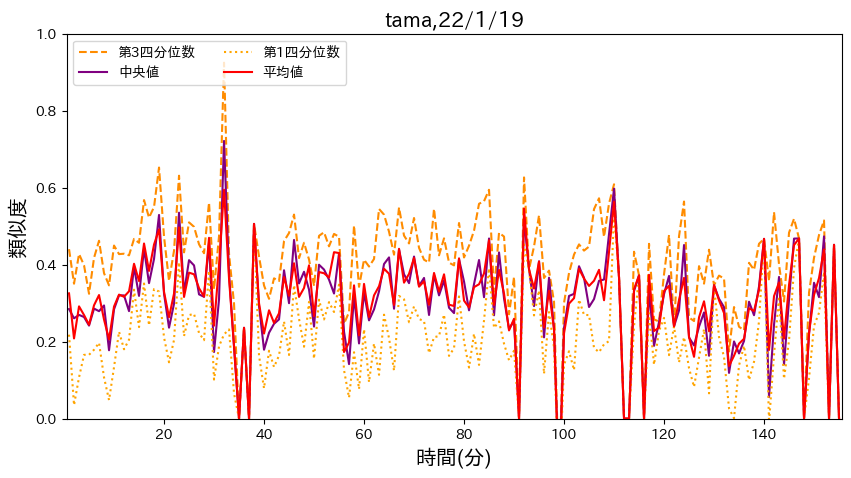

In [18]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/19", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


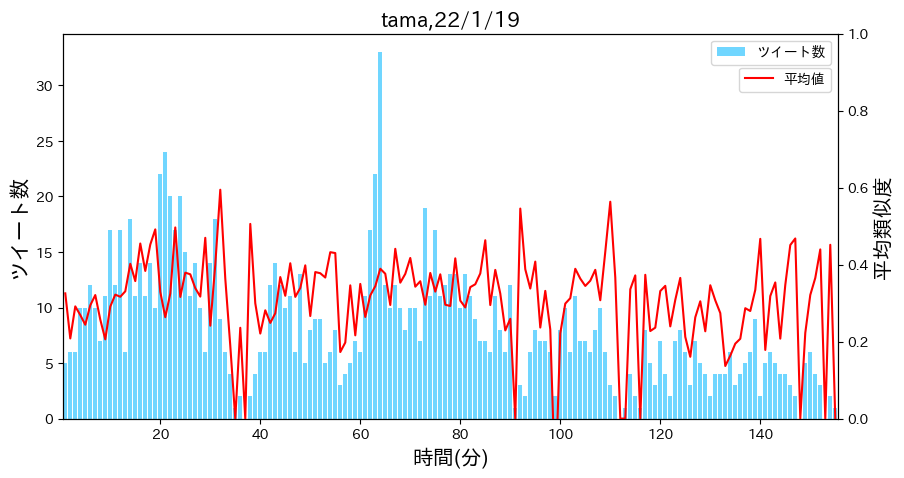

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/19", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


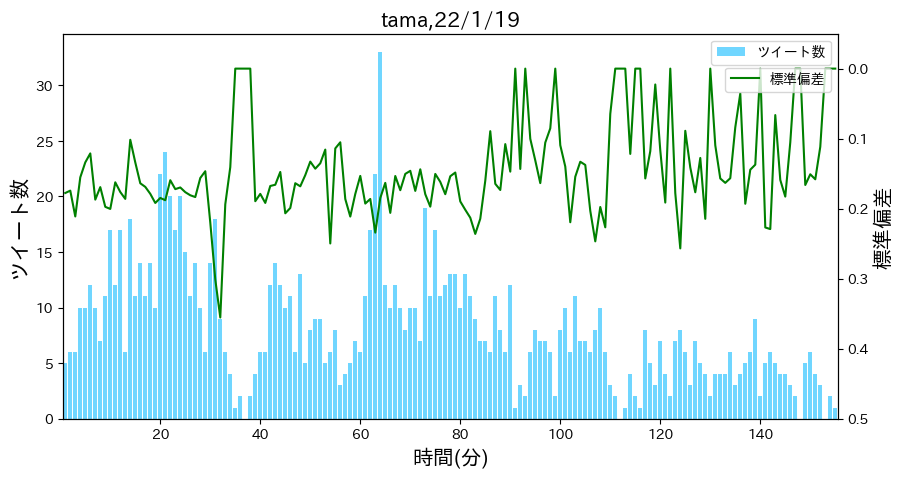

In [20]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/19", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
